In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## 합성곱 층

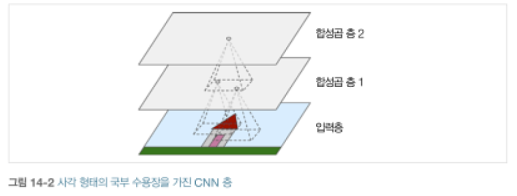

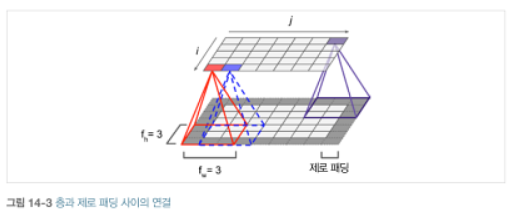

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

### 필터

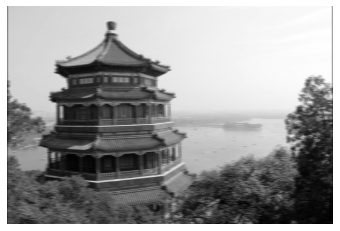

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

# 전체 뉴런에 적용된 하나의 필터는 하나의 특성 맵을 만든다.
# 이 맵은 필터를 가장 크게 활성화 시키는 이미지의 영역을 강조한다.
# 훈련하는 동안 합성곱 층이 자동으로 해당 문제에 가장 유용한 필터를 찾고,
# 상위층은 이들을 연결하여 더 복잡한 패턴을 학습한다.

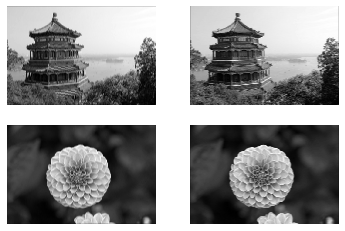

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

### 여러 가지 특성

In [5]:
# 실제 합성곱층은 여러가지 필터를 가지고 필터마다 하나의 특성 맵을 출력하므로
# 2D 가 아닌 3D 로 표현하는 것이 더 정확하다.

# 각 특성 맵의 픽셀은 하나의 뉴런에 해당하고,
# 하나의 특성 맵 안에서는 모든 뉴런이 같은 파라미터를 공유 하지만, 
# 다른 특성 맵에 있는 뉴런은 다른 파라미터를 사용한다.

# 입력 이미지는 컬러 채널마다 하나씩 여러 서브층으로 구성되기도 한다.
# (R,G,B) <=> 흑백 이미지는 하나의 채널만 가진다.
## 위성 이미지는 가시광선 외에도 다른 빛의 파장이 기록되서 매우 많은 채널을 가질 수 있다.

### 텐서플로 구현

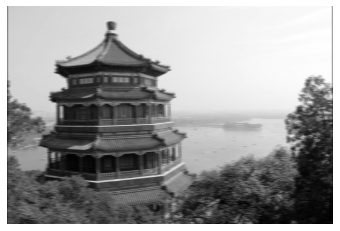

In [6]:
# 텐서플로에서 입력이미지는 보통 [높이, 너비, 채널] 형태의 3D 텐서로 표현된다.
# 하나의 미니배치는 [미니배치 크기, 높이, 너비, 채널] 형태의 4D 텐서로 표현된다.
# 합성곱층의 가중치는 4D 텐서로 표현된다.
# 합성곱층의 편향은 간단하게 1D 텐서로 표현된다.

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
# 각 컬러 채널의 픽셀 강도는 0~255 사이의 값이다.
# 이를 255로 나누어 0 ~ 1 사이의 실수로 바꾼다.

images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  
filters[3, :, :, 1] = 1  
# 두 개의 7*7 필터를 만든다.

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
# 필터를 두 이미지에 적용한다.
# (입력의 미니배치, 적용될 일련의 필터 , 스트라이드 , 패딩)

plt.imshow(outputs[0, :, :, 1], cmap="gray") 
plt.axis("off") 
plt.show()

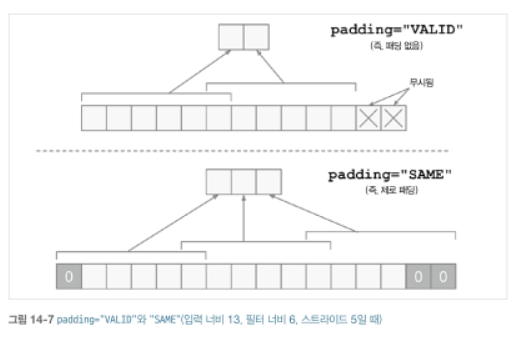

In [7]:
conv = keras.layers.Conv2D(filters = 32 , kernel_size=3, strides = 1, padding='same', activation='relu')

## 풀링층

In [8]:
# 이 층의 목적은 계산량과 메모리 사용량, 파라미터 수를 줄이기 위해 입력 이미지의 축소본을 만드는 것이다.

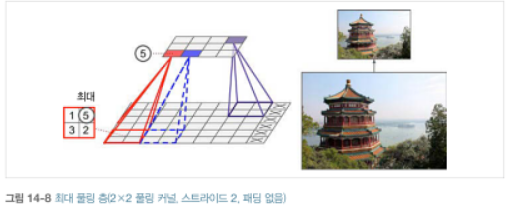

In [9]:
# 최대 풀링은 작은 변화에도 일정 수준의 불변성을 만들어 준다.
# CNN 에서 몇 개 층마다 최대 풀링 층을 추가하면 전체적으로 일정 수준의 이동 불변성을 얻을 수 있다.
# 또한 최대 풀링은 회전과 확대, 축소에 대해 약간의 불변성을 제공한다.

# 단점
# 작은 2*2 커널과 스트라이드 2 를 사용하더라도 출력은 양방향으로 절반이 줄어들어
# 입력값이 75% 를 잃게 된다. (매우 파괴적임)
# 어떤 어플리케이션에서는 불변성이 필요치 않다.

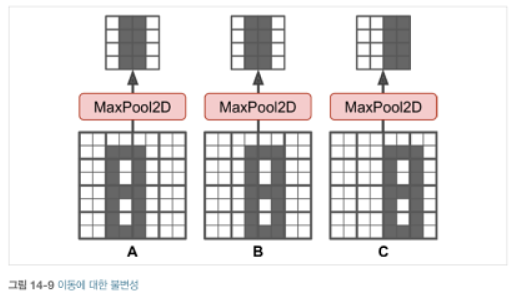

### 텐서플로 구현

In [10]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
# 2*2 커널을 사용해 최대 풀링층을 만든다.
# 기본적으로 valid 패딩을 사용한다.

# 일반적으로 최대 풀링 층이 성능이 좋아 다른 풀링보다 많이 사용한다.
# 최대 풀링은 의미없는 것은 모두 제거하고 가장 큰 특징만 유지한다.

In [11]:
# 깊이방향 최대 풀링층
output = tf.nn.max_pool(images, ksize = (1,1,1,1), strides= (1,1,1,3), padding='VALID')

depth_pool = keras.layers.Lambda(
    lambda X : tf.nn.max_pool(X, ksize=(1,1,1,3), strides = (1,1,1,3), padding='valid')
)

# (1,1,1,깊이 차원)
## 배치 높이 너비 차원을 따라 커널 크기와 스트라이드가 1이란 뜻이다.
## 깊이차원은 입력 깊이를 나누었을 때 떨어지는 값이어야 한다.

In [12]:
# 전역 평균 풀링층
## 각 특성 맵의 평균을 계산하는 것.
## == 각 샘플의 특성 맵마다 하나의 숫자를 출력한다.
## 출력층에서 유용하게 사용할 수 있다.

global_avg_pool = keras.layers.GlobalAvgPool2D()

global_avg_pool = keras.layers.Lambda(lambda X : tf.reduce_mean(X, axis=[1,2]))

## CNN 구조

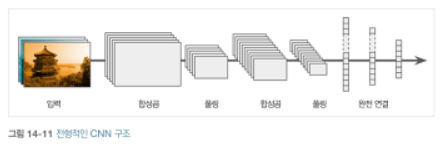

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64,7, activation= 'relu', padding ='same' , input_shape=[28, 28, 1]),
    # 64개의 7 * 7 필터 사용. 스트라이드는 기본적으로 (1.1)
    keras.layers.MaxPooling2D(pool_size=2),
    # 풀링 크기가 2인 최대 풀링층
    keras.layers.Conv2D(128, 3 , activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3 , activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    # 풀링층 다음에 필터 갯수를 두 배로 늘리는 것이 일반적인 방법임.
    keras.layers.Conv2D(256, 3 , activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3 , activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    # 샘플의 특성을 1D 배열로 펼친다.
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    # 과대적합을 줄이기 위해 50%의 드롭아웃 추가
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 1.0445 - accuracy: 0.6291 - val_loss: 0.4204 - val_accuracy: 0.8520
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4408 - accuracy: 0.8527 - val_loss: 0.3423 - val_accuracy: 0.8724
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3730 - accuracy: 0.8760 - val_loss: 0.3422 - val_accuracy: 0.8802
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3365 - accuracy: 0.8879 - val_loss: 0.2977 - val_accuracy: 0.8924
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2974 - accuracy: 0.8987 - val_loss: 0.3070 - val_accuracy: 0.8938
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2781 - accuracy: 0.9072 - val_loss: 0.2823 - val_accuracy: 0.8934
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2641 - accuracy: 0.9107 - val_loss: 0.2968 - val_ac

## 케라스를 사용해 ResNet-34 CNN 구현하기

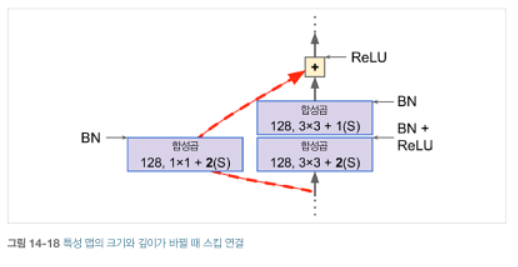

In [16]:
class ResidualUnit(keras.layers.Layer):
  def __init__ (self, filters, strides = 1, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,
      keras.layers.Conv2D(filters, 3, strides = 1, padding= 'same', use_bias=False),
      keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1 :
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides , padding = 'same', use_bias=False),
        keras.layers.BatchNormalization()
      ]
  # main_layers 가 오른쪽 모듈
  # skip_layers 가 왼쪽 모듈
  def call(self , inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    
    return self.activation(Z + skip_Z)

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [224,224,3], padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2,padding='same'))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## 케라스에서 제공하는 사전훈련된 모델 사용하기

In [19]:
# keras.applications 패키지에서 사전훈련된 모델을 불러올 수 있다.
model = keras.applications.resnet50.ResNet50(weights='imagenet')

# ResNet-50 모델은 224*224 픽셀 크기의 이미지를 기대한다.

102973440/102967424 [==============================] - 3s 0us/step


In [20]:
image_resized = tf.image.resize(images , [224,224])
# resize 함수는 가로세로 비율을 유지하지 않는다.

In [21]:
inputs = keras.applications.resnet50.preprocess_input(image_resized * 255)
# 모델마다 이미지를 전처리 해주는 preprocess_input() 함수를 제공한다.
# 이 함수는 픽셀값이 0~255 라고 가정한다.

In [22]:
Y_proba = model.predict(inputs)

In [23]:
Y_proba.shape
# 행이 하나의 이미지이고, 열이 하나의 클래스인 행렬이다.
# (1000개의 클래스)

(2, 1000)

In [24]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print('이미지 #{}'.format(image_index))
  for class_id , name, y_proba in top_K[image_index]:
    print("    {} - {:12s} {:.2f}%".format(class_id, name, y_proba *100))
    print()
    # 최상위 K 개의 예측을 클래스 이름과 예측 클래스의 추정확률을 출력한다.
    # 각 예측은 클래스 아이디, 이름, 확률을 포함한 튜플이다.

40960/35363 [==================================] - 0s 0us/step
이미지 #0
    n02825657 - bell_cote    82.35%

    n03877845 - palace       6.75%

    n03781244 - monastery    4.19%

이미지 #1
    n03530642 - honeycomb    49.83%

    n13040303 - stinkhorn    33.95%

    n02206856 - bee          4.35%



## 사전훈련된 모델을 사용한 전이 학습

In [25]:
# 충분하지 않은 훈련 데이터로 이미지 분류기 훈련 시 사전훈련된 모델의 하위층을 사용하는 것이 좋다.

import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
# with_info = True : 데이터셋에 대한 정보를 얻을 수 있음 (데이터셋의 크기, 클래스의 이름)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [26]:
info.splits['train'].num_examples

3670

In [27]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [28]:
num_classes = info.features['label'].num_classes

In [29]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)
# 데이터셋을 나눈다.

In [30]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label
  # xception 모델은 224 * 224 크기 이미지를 기대한다.

In [31]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)
# 훈련 세트를 섞은 뒤, 전처리함수를 3개의 데이터셋에 적용한다.
# 그다음 배치크기를 지정하고, 프리페치를 적용한다.

In [32]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs = output)
# 사전훈련된 Xception 모델을 로드한다. include_top = False 로 지정하여 네트워크 최상층의
## 전역 평균 풀링층 과 밀집 출력층을 제외시킨다.
## 이 기반 모델의 출력을 바탕으로 새로운 전역 평균 풀링층을 추가하고,
## 그 뒤에 클래스마다 하나의 유닛과 소프트맥스 활성화 함수를 가진 Dense 층을 놓는다.
## 마지막으로 케라스의 Model 클래스 객체를 만든다.

83689472/83683744 [==============================] - 1s 0us/step


In [33]:
for layer in base_model.layers:
  layer.trainable = False
  # 사전훈련된 층의 가중치를 동결한다.

In [34]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set , epochs=5 , validation_data = valid_set)

Epoch 1/5
86/86 [==============================] - 12s 103ms/step - loss: 2.8115 - accuracy: 0.6507 - val_loss: 1.4193 - val_accuracy: 0.8294
Epoch 2/5
86/86 [==============================] - 8s 91ms/step - loss: 0.7222 - accuracy: 0.8978 - val_loss: 0.9613 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 8s 91ms/step - loss: 0.3231 - accuracy: 0.9398 - val_loss: 1.0411 - val_accuracy: 0.8548
Epoch 4/5
86/86 [==============================] - 8s 92ms/step - loss: 0.2416 - accuracy: 0.9481 - val_loss: 0.9339 - val_accuracy: 0.8548
Epoch 5/5
86/86 [==============================] - 8s 92ms/step - loss: 0.1126 - accuracy: 0.9676 - val_loss: 0.8892 - val_accuracy: 0.8566


In [35]:
for layer in base_model.layers:
  layer.trainable = True
# 모든 층(또는 상위층의 일부)의 동결을 해제하고 훈련을 재개한다.
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
# 사전훈련된 가중치가 훼손되는 것을 피하기 위해 훨씬 작은 학습률을 사용한다.
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set , epochs=5 , validation_data = valid_set)

Epoch 1/5
86/86 [==============================] - 38s 403ms/step - loss: 0.5559 - accuracy: 0.8216 - val_loss: 0.4875 - val_accuracy: 0.8857
Epoch 2/5
86/86 [==============================] - 34s 396ms/step - loss: 0.0783 - accuracy: 0.9770 - val_loss: 0.2619 - val_accuracy: 0.9183
Epoch 3/5
86/86 [==============================] - 34s 398ms/step - loss: 0.0259 - accuracy: 0.9932 - val_loss: 0.2904 - val_accuracy: 0.9165
Epoch 4/5
86/86 [==============================] - 34s 397ms/step - loss: 0.0222 - accuracy: 0.9951 - val_loss: 0.2765 - val_accuracy: 0.9238
Epoch 5/5
86/86 [==============================] - 34s 396ms/step - loss: 0.0126 - accuracy: 0.9969 - val_loss: 0.2648 - val_accuracy: 0.9201


## 분류와 위치 추정

In [35]:
# 물체 주위의 바운딩 박스를 예측하는 일반적인 방법은
# 물체 중심의 수평, 수직 좌표와 높이, 너비를 예측하는 것이다. (4개의 숫자를 예측해야함.)
## 때문에 모델을 크게 바꿀 필요는 없다.
## (일반적으로 전역 평균 풀링층 위에) 네 개의 유닛을 가진 두번째 밀집 출력 층을 추가하고,
### MSE 손실을 사용해 훈련한다.

In [37]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                  include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(num_classes , activation = 'softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs = base_model.input,
                    outputs=[class_output, loc_output])
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], 
              loss_weights = [0.8, 0.2],
              optimizer = optimizer, metrics=['accuracy'])

In [38]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
# 가상의 바운딩 박스를 만든다.

In [39]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 5s 382ms/step - loss: 1.3780 - dense_5_loss: 1.6306 - dense_6_loss: 0.3678 - dense_5_accuracy: 0.1784 - dense_6_accuracy: 0.2317
Epoch 2/2
5/5 [==============================] - 2s 384ms/step - loss: 1.2419 - dense_5_loss: 1.4892 - dense_6_loss: 0.2524 - dense_5_accuracy: 0.4003 - dense_6_accuracy: 0.2438
